In [1]:
import pickle

In [2]:
import numpy as np

In [3]:
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)
    
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
type(test_data)

list

In [5]:
type(train_data)

list

In [6]:
len(test_data)

1000

In [7]:
len(train_data)

10000

In [8]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [9]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [10]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [11]:
train_data[0][2]

'no'

In [12]:
all_data = test_data + train_data

In [13]:
len(all_data)

11000

In [14]:
vocab = set()
for story,question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [15]:
vocab.add('no')

In [16]:
vocab.add('yes')

In [17]:
vocab_len = len(vocab) + 1

In [18]:
vocab_len

38

In [19]:
# Longest Story
all_story_lens = [len(data[0]) for data in all_data]

In [20]:
max_story_len = max(all_story_lens)

In [21]:
max_question_len = max([len(data[1]) for data in all_data])


In [22]:
max_question_len

6

In [23]:
max_story_len

156

In [24]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [25]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [26]:
tokenizer.word_index

{'office': 1,
 'milk': 2,
 '.': 3,
 'football': 4,
 'the': 5,
 'in': 6,
 'up': 7,
 'mary': 8,
 'back': 9,
 'picked': 10,
 'journeyed': 11,
 'bedroom': 12,
 'grabbed': 13,
 'went': 14,
 'no': 15,
 'put': 16,
 'hallway': 17,
 'got': 18,
 'is': 19,
 'yes': 20,
 'took': 21,
 'down': 22,
 'discarded': 23,
 'garden': 24,
 'daniel': 25,
 'apple': 26,
 'bathroom': 27,
 '?': 28,
 'sandra': 29,
 'left': 30,
 'there': 31,
 'kitchen': 32,
 'john': 33,
 'dropped': 34,
 'moved': 35,
 'to': 36,
 'travelled': 37}

In [35]:
train_story_text = []
train_question_text = []
train_answers = []


In [36]:
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [37]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [38]:
len(train_story_seq)

10000

In [42]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    #Stories
    X = []
    # Question
    Xq = []
    # Y question Answer (yes/no)
    Y = []
    
    for story,query,answer in data:
        # for each story
        # [23,16,......]
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    return(pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

In [43]:
inputs_train, queries_train, answer_train = vectorize_stories(train_data)

In [44]:
inputs_test, queries_test, answer_test = vectorize_stories(test_data)

In [45]:
inputs_test

array([[ 0,  0,  0, ...,  5, 12,  3],
       [ 0,  0,  0, ...,  5, 24,  3],
       [ 0,  0,  0, ...,  5, 24,  3],
       ...,
       [ 0,  0,  0, ...,  5, 26,  3],
       [ 0,  0,  0, ...,  5, 24,  3],
       [ 0,  0,  0, ..., 26, 31,  3]])

In [47]:
tokenizer.word_index['yes']

20

In [48]:
tokenizer.word_index['no']

15

In [49]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0., 497.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [50]:
from keras.models import Sequential,Model

In [51]:
from keras.layers.embeddings import Embedding

In [52]:
from keras.layers import Input,Activation,Dense, Permute, Dropout,add, dot,concatenate, LSTM

In [53]:
# Placeholder
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [54]:
# vocab len
vocab_size = len(vocab) + 1

In [55]:
# Input encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))


In [56]:
# Input encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))


In [57]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [58]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [59]:
match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation('softmax')(match)

In [60]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [71]:
answer = concatenate([response,question_encoded])

In [72]:
answer

<tf.Tensor 'concatenate_3/concat:0' shape=(?, 6, 220) dtype=float32>

In [73]:
answer = LSTM(32)(answer)

In [74]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [76]:
answer = Activation('softmax')(answer)

In [77]:
model = Model([input_sequence,question],answer)

In [78]:
model.compile(optimizer = 'rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [80]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [83]:
history = model.fit([inputs_train,queries_train],answer_train,batch_size=32,epochs=25,validation_data=([inputs_test,queries_test],answer_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/25
10000/10000 [==============================] - 10s 954us/step - loss: 3.0210 - acc: 0.6743 - val_loss: 3.0052 - val_acc: 0.6890
Epoch 2/25
10000/10000 [==============================] - 9s 908us/step - loss: 3.0029 - acc: 0.6853 - val_loss: 2.9898 - val_acc: 0.6970
Epoch 3/25
10000/10000 [==============================] - 10s 978us/step - loss: 2.9829 - acc: 0.7031 - val_loss: 2.9491 - val_acc: 0.7410
Epoch 4/25
10000/10000 [==============================] - 10s 979us/step - loss: 2.9644 - acc: 0.7243 - val_loss: 2.9352 - val_acc: 0.7500
Epoch 5/25
10000/10000 [==============================] - 10s 960us/step - loss: 2.9517 - acc: 0.7356 - val_loss: 2.9341 - val_acc: 0.7480
Epoch 6/25
10000/10000 [==============================] - 10s 999us/step - loss: 2.9395 - acc: 0.7473 - val_loss: 2.9265 - val_acc: 0.7540
Epoch 7/25
10000/10000 [==============================] - 11s 1ms/step - loss: 2.9300 - acc: 0.7549 - val_loss: 2.9083

In [84]:
filename = 'chatbot_model.h5'
model.save(filename)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


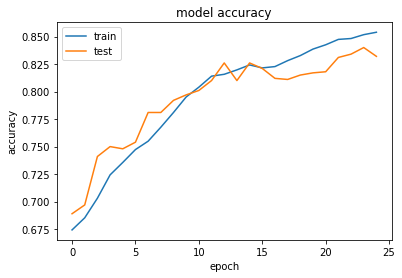

<Figure size 432x288 with 0 Axes>

In [113]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig('screenshot.png',bbox_inches='tight')

In [87]:
pred_results = model.predict(([inputs_test,queries_test]))

In [88]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [89]:
pred_results.shape[0]

1000

In [90]:
val_max = np.argmax(pred_results[0])

In [92]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [93]:
k

'no'

In [94]:
pred_results[0][val_max]

0.06843902

In [95]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [96]:
my_story = "John Left the kitchen . Sandra dropped the football in the garden ."

In [97]:
my_story.split()

['John',
 'Left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [98]:
my_question = "Is the football in the garden ?"

In [99]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [101]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [102]:
my_story, my_ques, my_answ = vectorize_stories(mydata) 

In [104]:
my_answ

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [105]:
pred_results = model.predict(([my_story, my_ques]))

In [106]:
val_max  = np.argmax(pred_results[0])

In [107]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [108]:
k

'no'